# Customer Return Clustering - Complete Pipeline Handler
# Orchestrates the entire pipeline from data loading to clustering results

**Execute each cell in order to run the complete customer clustering pipeline.**

In [1]:
# Setup and imports
import sys
import subprocess
import pandas as pd
import numpy as np
import logging
from pathlib import Path
import json
from datetime import datetime
import traceback
import time

# Setup comprehensive logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(module)s - %(message)s',
    handlers=[
        logging.FileHandler(f'pipeline_execution_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

print("📦 Imports completed successfully!")

📦 Imports completed successfully!


In [2]:
# PIPELINE CONFIGURATION - UPDATE YOUR CSV FILE PATH HERE!

# ENHANCED PIPELINE CONFIGURATION
PIPELINE_CONFIG = {
    'data_source': {
        'csv_file': 'base_returns_sku_reasoncodes_sent.csv',  # Your new CSV!
        'expected_columns': [
            # All 31 columns including GROSS, SENTIMENT, SCORE, etc.
            'SALES_ORDER_NO', 'CUSTOMER_EMAILID', 'ORDER_DATE', 'SKU', 
            'SALES_QTY', 'GROSS', 'RETURN_QTY', 'UNITS_RETURNED_FLAG', 
            'RETURN_DATE', 'RETURN_NO', 'RETURN_COMMENT', 'RETURN_REASON',
            'ORDERLINK', 'MAX(RR.F_ID)', 'MAX(RR.F_NAME)', 
            'MAX(RR.Q_D2C_RTRN_REASONCODE_ID)', 'MAX(RR.Q_D2C_RET_REASON_NAME)',
            'MAX(RR.Q_D2C_RET_REASON)', 'MAX(RR.Q_D2C_RET_REASON_GROUP_NAME0)',
            'Q_CLS_ID', 'Q_SKU_DESC', 'Q_GMM_ID', 'Q_SKU_ID', 'CLASS_', 
            'DIVISION_', 'BRAND_', 'Q_CLR_DNUM', 'Q_CLR_DESC', 
            'VENDOR_STYLE', 'SIZE_', 'SENTIMENT', 'SCORE'
        ]
    },
    
    'execution_steps': {
        'database_setup': False,
        'data_analysis': True,
        'feature_creation': True,
        'preprocessing': True,
        'clustering': True  # Set to True to run clustering automatically
    },
    
    'error_handling': {
        'continue_on_warning': True,
        'stop_on_error': True,
        'save_intermediate_results': True,
        'max_retries': 2
    },
    
    'quality_checks': {
        'min_customers': 1000,
        'min_orders_per_customer': 2,
        'max_missing_data_ratio': 0.3,
        'min_feature_completeness': 0.5
    }
}

print("="*80)
print("CUSTOMER RETURN CLUSTERING - COMPLETE PIPELINE")
print("🎉 ENHANCED WITH ALL 22 CSV COLUMNS!")
print("="*80)
print(f"Pipeline execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"CSV File: {PIPELINE_CONFIG['data_source']['csv_file']}")
print(f"Using {len(PIPELINE_CONFIG['data_source']['expected_columns'])} columns including bonus data!")

# Check if CSV file exists
csv_path = Path(PIPELINE_CONFIG['data_source']['csv_file'])
if csv_path.exists():
    print(f"✅ CSV file found: {csv_path} ({csv_path.stat().st_size / 1024 / 1024:.1f} MB)")
    print("✨ Bonus features available:")
    bonus_cols = ['ORDERLINK', 'Q_SKU_DESC', 'Q_GMM_ID', 'DIVISION_', 
                  'Q_CLR_DNUM', 'Q_CLR_DESC', 'VENDOR_STYLE', 'SIZE_']
    for col in bonus_cols:
        print(f"   📊 {col} - Enhanced clustering features possible!")
else:
    print(f"❌ CSV file not found: {csv_path}")

CUSTOMER RETURN CLUSTERING - COMPLETE PIPELINE
🎉 ENHANCED WITH ALL 22 CSV COLUMNS!
Pipeline execution started at: 2025-06-25 09:38:07
CSV File: base_returns_sku_reasoncodes_sent.csv
Using 32 columns including bonus data!
✅ CSV file found: base_returns_sku_reasoncodes_sent.csv (715.4 MB)
✨ Bonus features available:
   📊 ORDERLINK - Enhanced clustering features possible!
   📊 Q_SKU_DESC - Enhanced clustering features possible!
   📊 Q_GMM_ID - Enhanced clustering features possible!
   📊 DIVISION_ - Enhanced clustering features possible!
   📊 Q_CLR_DNUM - Enhanced clustering features possible!
   📊 Q_CLR_DESC - Enhanced clustering features possible!
   📊 VENDOR_STYLE - Enhanced clustering features possible!
   📊 SIZE_ - Enhanced clustering features possible!


In [3]:
# Pipeline execution utilities class

class PipelineExecutor:
    def __init__(self, config):
        self.config = config
        self.execution_log = []
        self.start_time = time.time()
        self.step_times = {}
        
    def log_step(self, step_name, status, duration=None, details=None):
        """Log pipeline step execution"""
        log_entry = {
            'step': step_name,
            'status': status,
            'timestamp': datetime.now().isoformat(),
            'duration_seconds': duration,
            'details': details
        }
        self.execution_log.append(log_entry)
        
        if duration:
            logger.info(f"Step '{step_name}' {status.lower()} in {duration:.2f} seconds")
        else:
            logger.info(f"Step '{step_name}' {status.lower()}")
    
    def run_python_module(self, module_name, description, *args):
        """Execute a Python module and handle errors"""
        step_start = time.time()
        
        try:
            logger.info(f"Starting: {description}")
            
            if module_name == 'db':
                from db import setup_database  # ✅ Use enhanced version
                db = setup_database(self.config['data_source']['csv_file'])
                summary = db.get_data_summary()  # ✅ Enhanced summary
                db.close()
                result = summary
                
            elif module_name == 'create_features':
                result = subprocess.run([
                    sys.executable, 'create_features.py'
                ], capture_output=True, text=True, check=True)
                result = {'stdout': result.stdout, 'stderr': result.stderr}
                
            elif module_name == 'cluster_preprocessing':
                result = subprocess.run([
                    sys.executable, 'cluster_preprocessing.py'
                ] + list(args), capture_output=True, text=True, check=True)
                result = {'stdout': result.stdout, 'stderr': result.stderr}
                
            else:
                raise ValueError(f"Unknown module: {module_name}")
            
            duration = time.time() - step_start
            self.step_times[module_name] = duration
            self.log_step(description, "COMPLETED", duration, result)
            
            return True, result
            
        except subprocess.CalledProcessError as e:
            duration = time.time() - step_start
            error_details = {
                'error_type': 'subprocess_error',
                'return_code': e.returncode,
                'stdout': e.stdout,
                'stderr': e.stderr
            }
            self.log_step(description, "FAILED", duration, error_details)
            logger.error(f"Subprocess failed: {e}")
            logger.error(f"STDOUT: {e.stdout}")
            logger.error(f"STDERR: {e.stderr}")
            
            return False, error_details
            
        except Exception as e:
            duration = time.time() - step_start
            error_details = {
                'error_type': 'execution_error',
                'error_message': str(e),
                'traceback': traceback.format_exc()
            }
            self.log_step(description, "FAILED", duration, error_details)
            logger.error(f"Execution failed: {e}")
            logger.error(f"Traceback: {traceback.format_exc()}")
            
            return False, error_details
    
    def save_execution_summary(self):
        """Save comprehensive execution summary"""
        total_duration = time.time() - self.start_time
        
        summary = {
            'pipeline_execution': {
                'start_time': datetime.fromtimestamp(self.start_time).isoformat(),
                'end_time': datetime.now().isoformat(),
                'total_duration_seconds': total_duration,
                'total_duration_formatted': f"{total_duration//3600:.0f}h {(total_duration%3600)//60:.0f}m {total_duration%60:.0f}s"
            },
            'configuration': self.config,
            'step_execution_log': self.execution_log,
            'step_durations': self.step_times,
            'status_summary': {
                'total_steps': len(self.execution_log),
                'completed_steps': len([log for log in self.execution_log if log['status'] == 'COMPLETED']),
                'failed_steps': len([log for log in self.execution_log if log['status'] == 'FAILED'])
            }
        }
        
        # Save to JSON
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        with open(f'pipeline_execution_summary_{timestamp}.json', 'w') as f:
            json.dump(summary, f, indent=2, default=str)
        
        logger.info(f"Execution summary saved to pipeline_execution_summary_{timestamp}.json")
        return summary

# Initialize pipeline executor
pipeline = PipelineExecutor(PIPELINE_CONFIG)
print("✅ Pipeline executor initialized!")

✅ Pipeline executor initialized!


In [4]:
# STEP 1: DATABASE SETUP AND DATA LOADING

if PIPELINE_CONFIG['execution_steps']['database_setup']:
    print("\n" + "="*60)
    print("STEP 1: DATABASE SETUP AND DATA LOADING")
    print("="*60)
    
    # Check if CSV file exists
    csv_path = Path(PIPELINE_CONFIG['data_source']['csv_file'])
    if not csv_path.exists():
        print(f"❌ CSV file not found: {csv_path}")
        print("Please update the csv_file path in PIPELINE_CONFIG")
        pipeline.log_step("Database Setup", "FAILED", details="CSV file not found")
    else:
        print(f"✅ CSV file found: {csv_path} ({csv_path.stat().st_size / 1024 / 1024:.1f} MB)")
        
        # Execute database setup
        success, result = pipeline.run_python_module('db', 'Database Setup and Data Loading')
        
        if success:
            print(f"\n✅ Database setup completed successfully!")
            print(f"Data summary: {result}")
        else:
            print(f"❌ Database setup failed: {result}")
            if PIPELINE_CONFIG['error_handling']['stop_on_error']:
                print("Stopping pipeline due to error configuration")
                raise Exception("Database setup failed")
else:
    print("⏭️ Database setup skipped (disabled in configuration)")

⏭️ Database setup skipped (disabled in configuration)


In [5]:
# STEP 2: DATA ANALYSIS

if PIPELINE_CONFIG['execution_steps']['data_analysis']:
    print("\n" + "="*60)
    print("STEP 2: DATA ANALYSIS")
    print("="*60)
    
    step_start = time.time()
    
    try:
        print("Running basic data analysis...")
        
        from db import get_connection
        conn = get_connection("customer_clustering.db")
        
        # Run key analyses
        print("Analyzing customer distribution...")
        customer_analysis = conn.execute("""
            WITH customer_summary AS (
                SELECT 
                    customer_emailid,
                    count(DISTINCT sales_order_no) as order_count,
                    count(*) as item_count,
                    sum(sales_qty) as total_sales_qty,
                    sum(return_qty) as total_return_qty,
                    min(order_date) as first_order,
                    max(order_date) as last_order
                FROM bronze_return_order_data
                GROUP BY customer_emailid
            )
            SELECT 
                count(*) as total_customers,
                avg(order_count) as avg_orders_per_customer,
                avg(total_sales_qty) as avg_qty_per_customer,
                avg(CAST(total_return_qty AS DOUBLE) / CAST(total_sales_qty AS DOUBLE)) as avg_return_rate,
                count(*) FILTER (WHERE order_count >= ?) as customers_with_sufficient_orders
            FROM customer_summary;
        """, [PIPELINE_CONFIG['quality_checks']['min_orders_per_customer']]).fetchone()
        
        conn.close()
        
        duration = time.time() - step_start
        
        analysis_results = {
            'total_customers': customer_analysis[0],
            'avg_orders_per_customer': customer_analysis[1],
            'avg_qty_per_customer': customer_analysis[2],
            'avg_return_rate': customer_analysis[3],
            'customers_with_sufficient_orders': customer_analysis[4]
        }
        
        pipeline.log_step("Data Analysis", "COMPLETED", duration, analysis_results)
        
        print(f"✅ Data analysis completed in {duration:.2f} seconds")
        print(f"Analysis results:")
        for key, value in analysis_results.items():
            print(f"  {key}: {value:,.3f}" if isinstance(value, float) else f"  {key}: {value:,}")
        
        # Check if we have sufficient data quality
        sufficient_customers_ratio = analysis_results['customers_with_sufficient_orders'] / analysis_results['total_customers']
        if sufficient_customers_ratio < 0.5:
            print(f"⚠️ Warning: Only {sufficient_customers_ratio:.1%} customers have sufficient order history")
        else:
            print(f"✅ {sufficient_customers_ratio:.1%} customers have sufficient order history")
        
    except Exception as e:
        duration = time.time() - step_start
        pipeline.log_step("Data Analysis", "FAILED", duration, str(e))
        print(f"❌ Data analysis failed: {e}")
        
        if PIPELINE_CONFIG['error_handling']['stop_on_error']:
            print("Stopping pipeline due to error configuration")
            raise
else:
    print("⏭️ Data analysis skipped (disabled in configuration)")


STEP 2: DATA ANALYSIS
Running basic data analysis...
Analyzing customer distribution...
2025-06-25 09:38:08,195 - INFO - 4185141521 - Step 'Data Analysis' completed in 0.20 seconds
✅ Data analysis completed in 0.20 seconds
Analysis results:
  total_customers: 14,999
  avg_orders_per_customer: 67.407
  avg_qty_per_customer: 259.890
  avg_return_rate: 0.214
  customers_with_sufficient_orders: 14,999
✅ 100.0% customers have sufficient order history
2025-06-25 09:38:08,195 - INFO - 4185141521 - Step 'Data Analysis' completed in 0.20 seconds
✅ Data analysis completed in 0.20 seconds
Analysis results:
  total_customers: 14,999
  avg_orders_per_customer: 67.407
  avg_qty_per_customer: 259.890
  avg_return_rate: 0.214
  customers_with_sufficient_orders: 14,999
✅ 100.0% customers have sufficient order history


In [6]:
# STEP 3: FEATURE CREATION

if PIPELINE_CONFIG['execution_steps']['feature_creation']:
    print("\n" + "="*60)
    print("STEP 3: FEATURE CREATION")
    print("="*60)
    
    success, result = pipeline.run_python_module('create_features', 'Feature Engineering and Silver Layer Creation')
    
    if success:
        print("✅ Feature creation completed successfully!")
        print("Silver layer populated with customer features")
        print("\n📊 Created 37 features across 10 categories:")
        print("  - Volume Metrics (5 features)")
        print("  - Return Behavior (6 features)")
        print("  - Temporal Patterns (6 features)")
        print("  - Recency Analysis (4 features)")
        print("  - Category Intelligence (3 features)")
        print("  - Consecutive Returns (2 features)")
        print("  - Adjacency Patterns (4 features)")
        print("  - Seasonal Trends (2 features)")
        print("  - Trend Analysis (2 features)")
        print("  - Monetary Value Metrics (3 features)")
        print("\nNext: Running feature analytics and generating Excel report...")
            
    else:
        print(f"❌ Feature creation failed")
        print(f"Error details: {result}")
        
        if PIPELINE_CONFIG['error_handling']['stop_on_error']:
            print("Stopping pipeline due to error configuration")
            raise Exception("Feature creation failed")
else:
    print("⏭️ Feature creation skipped (disabled in configuration)")


STEP 3: FEATURE CREATION
2025-06-25 09:38:08,207 - INFO - 4185141521 - Starting: Feature Engineering and Silver Layer Creation


Exception in thread Thread-3 (_readerthread):
Traceback (most recent call last):
  File "C:\Python312\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Code\Local Code\URBN\RETRO_hack_25\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Python312\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Python312\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Python312\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 253: character maps to <undefined>


2025-06-25 09:39:00,724 - INFO - 4185141521 - Step 'Feature Engineering and Silver Layer Creation' completed in 52.52 seconds
✅ Feature creation completed successfully!
Silver layer populated with customer features

📊 Created 37 features across 10 categories:
  - Volume Metrics (5 features)
  - Return Behavior (6 features)
  - Temporal Patterns (6 features)
  - Recency Analysis (4 features)
  - Category Intelligence (3 features)
  - Consecutive Returns (2 features)
  - Adjacency Patterns (4 features)
  - Seasonal Trends (2 features)
  - Trend Analysis (2 features)
  - Monetary Value Metrics (3 features)

Next: Running feature analytics and generating Excel report...
✅ Feature creation completed successfully!
Silver layer populated with customer features

📊 Created 37 features across 10 categories:
  - Volume Metrics (5 features)
  - Return Behavior (6 features)
  - Temporal Patterns (6 features)
  - Recency Analysis (4 features)
  - Category Intelligence (3 features)
  - Consecutive Re

In [7]:
# STEP 3.1: FEATURE ANALYTICS AND EXCEL EXPORT

if PIPELINE_CONFIG['execution_steps']['feature_creation']:
    print("\n" + "="*60)
    print("STEP 3.1: FEATURE ANALYTICS AND EXCEL EXPORT")
    print("="*60)
    
    step_start = time.time()
    
    try:
        print("Running feature analytics and generating Excel export...")
        
        from db import get_connection
        import pandas as pd
        import numpy as np
        from datetime import datetime
        
        # Connect to database
        conn = get_connection("customer_clustering.db")
        
        # Fetch all customer features from silver layer
        print("Fetching customer features from silver layer...")
        features_df = conn.execute("SELECT * FROM silver_customer_features").fetchdf()
        
        # Exclude non-numeric and metadata columns from statistical analysis
        exclude_cols = ['customer_emailid', 'customer_emailid_cleaned', 'customer_tenure_stage', 
                         'feature_calculation_date', 'data_quality_flags', 'first_order_date', 'last_order_date']
        
        # Get numeric columns
        numeric_cols = [col for col in features_df.columns if col not in exclude_cols]
        
        # Create a DataFrame for statistics
        print("Calculating feature statistics...")
        stats_dict = {
            'feature_name': [],
            'count': [],
            'null_count': [],
            'null_percent': [],
            'min': [],
            'max': [],
            'mean': [],
            'median': [],
            'std_dev': [],
            'p10': [],
            'p25': [],
            'p75': [],
            'p90': [],
            'p95': [],
            'p99': []
        }
        
        # Calculate statistics for each numeric feature
        for col in numeric_cols:
            stats_dict['feature_name'].append(col)
            stats_dict['count'].append(features_df[col].count())
            stats_dict['null_count'].append(features_df[col].isnull().sum())
            stats_dict['null_percent'].append(features_df[col].isnull().mean() * 100)
            stats_dict['min'].append(features_df[col].min())
            stats_dict['max'].append(features_df[col].max())
            stats_dict['mean'].append(features_df[col].mean())
            stats_dict['median'].append(features_df[col].median())
            stats_dict['std_dev'].append(features_df[col].std())
            stats_dict['p10'].append(features_df[col].quantile(0.10))
            stats_dict['p25'].append(features_df[col].quantile(0.25))
            stats_dict['p75'].append(features_df[col].quantile(0.75))
            stats_dict['p90'].append(features_df[col].quantile(0.90))
            stats_dict['p95'].append(features_df[col].quantile(0.95))
            stats_dict['p99'].append(features_df[col].quantile(0.99))
        
        # Create statistics DataFrame
        stats_df = pd.DataFrame(stats_dict)
        
        # Group features for correlation analysis
        feature_groups = {
            'Volume Metrics': ['sales_order_no_nunique', 'sku_nunique', 'items_returned_count', 
                              'sales_qty_mean', 'avg_order_size'],
            'Return Behavior': ['return_rate', 'return_ratio', 'return_product_variety', 
                               'avg_returns_per_order', 'return_frequency_ratio', 'return_intensity'],
            'Temporal Patterns': ['customer_lifetime_days', 'avg_days_to_return', 'return_timing_spread'],
            'Monetary Metrics': ['avg_order_value', 'avg_return_value', 'high_value_return_affinity']
        }
        
        # Calculate correlation matrices for each feature group
        correlation_dfs = {}
        for group_name, group_features in feature_groups.items():
            valid_features = [f for f in group_features if f in features_df.columns]
            if valid_features:
                correlation_dfs[group_name] = features_df[valid_features].corr()
        
        # Generate timestamp for the file
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        excel_file = f'customer_features_analysis_{timestamp}.xlsx'
        
        # Create Excel writer
        print(f"Exporting analytics to {excel_file}...")
        with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
            # Export feature statistics
            stats_df.to_excel(writer, sheet_name='Feature Statistics', index=False)
            
            # Export data sample (first 1000 rows)
            features_df.head(1000).to_excel(writer, sheet_name='Data Sample', index=False)
            
            # Export correlation matrices
            for group_name, corr_df in correlation_dfs.items():
                corr_df.to_excel(writer, sheet_name=f'Corr_{group_name[:20]}')
            
            # Export summary stats by customer segment
            if 'customer_tenure_stage' in features_df.columns:
                tenure_summary = features_df.groupby('customer_tenure_stage')[numeric_cols].agg(['mean', 'median', 'std'])
                tenure_summary.to_excel(writer, sheet_name='Tenure Segments')
        
        # Calculate high return customers and other business insights
        high_return_threshold = features_df['return_rate'].quantile(0.9)  # Top 10% by return rate
        high_value_threshold = features_df['avg_order_value'].quantile(0.9)  # Top 10% by order value
        
        high_return_count = (features_df['return_rate'] >= high_return_threshold).sum()
        high_value_count = (features_df['avg_order_value'] >= high_value_threshold).sum()
        high_return_high_value = ((features_df['return_rate'] >= high_return_threshold) & 
                                 (features_df['avg_order_value'] >= high_value_threshold)).sum()
        
        # Business insights
        business_insights = {
            'total_customers': len(features_df),
            'high_return_customers': high_return_count,
            'high_value_customers': high_value_count,
            'high_return_high_value': high_return_high_value,
            'avg_customer_lifetime_days': features_df['customer_lifetime_days'].mean(),
            'avg_return_rate': features_df['return_rate'].mean(),
            'avg_order_value': features_df['avg_order_value'].mean(),
            'high_return_rate_threshold': high_return_threshold,
            'high_value_threshold': high_value_threshold
        }
        
        # Close connection
        conn.close()
        
        duration = time.time() - step_start
        
        pipeline.log_step("Feature Analytics and Excel Export", "COMPLETED", duration, business_insights)
        
        print(f"✅ Feature analytics completed in {duration:.2f} seconds")
        print(f"📊 Excel file created: {excel_file}")
        print("\nBusiness Insights:")
        print(f"  Total Customers: {business_insights['total_customers']:,}")
        print(f"  High Return Customers: {business_insights['high_return_customers']:,} " +
              f"({business_insights['high_return_customers']/business_insights['total_customers']:.1%})")
        print(f"  High Value Customers: {business_insights['high_value_customers']:,} " +
              f"({business_insights['high_value_customers']/business_insights['total_customers']:.1%})")
        print(f"  High Return & High Value: {business_insights['high_return_high_value']:,} " +
              f"({business_insights['high_return_high_value']/business_insights['total_customers']:.1%})")
        print(f"  Average Customer Lifetime: {business_insights['avg_customer_lifetime_days']:.1f} days")
        print(f"  Average Return Rate: {business_insights['avg_return_rate']:.1%}")
        print(f"  Average Order Value (scaled): {business_insights['avg_order_value']:.2f}")
        
    except Exception as e:
        duration = time.time() - step_start
        pipeline.log_step("Feature Analytics and Excel Export", "FAILED", duration, str(e))
        print(f"❌ Feature analytics failed: {e}")
        print(traceback.format_exc())
        
        if PIPELINE_CONFIG['error_handling']['stop_on_error']:
            print("Stopping pipeline due to error configuration")
            raise


STEP 3.1: FEATURE ANALYTICS AND EXCEL EXPORT
Running feature analytics and generating Excel export...
Fetching customer features from silver layer...
Calculating feature statistics...
Exporting analytics to customer_features_analysis_20250625_093900.xlsx...
2025-06-25 09:39:01,800 - INFO - 4185141521 - Step 'Feature Analytics and Excel Export' completed in 1.04 seconds
✅ Feature analytics completed in 1.04 seconds
📊 Excel file created: customer_features_analysis_20250625_093900.xlsx

Business Insights:
  Total Customers: 14,999
  High Return Customers: 1,500 (10.0%)
  High Value Customers: 1,500 (10.0%)
  High Return & High Value: 330 (2.2%)
  Average Customer Lifetime: 939.5 days
  Average Return Rate: 21.4%
  Average Order Value (scaled): 27.20
2025-06-25 09:39:01,800 - INFO - 4185141521 - Step 'Feature Analytics and Excel Export' completed in 1.04 seconds
✅ Feature analytics completed in 1.04 seconds
📊 Excel file created: customer_features_analysis_20250625_093900.xlsx

Business In


STEP 3.2: FEATURE VISUALIZATIONS
Generating feature visualizations...
✅ Feature visualizations created and saved to customer_features_visualization_20250625_093903.png
✅ Feature visualizations created and saved to customer_features_visualization_20250625_093903.png


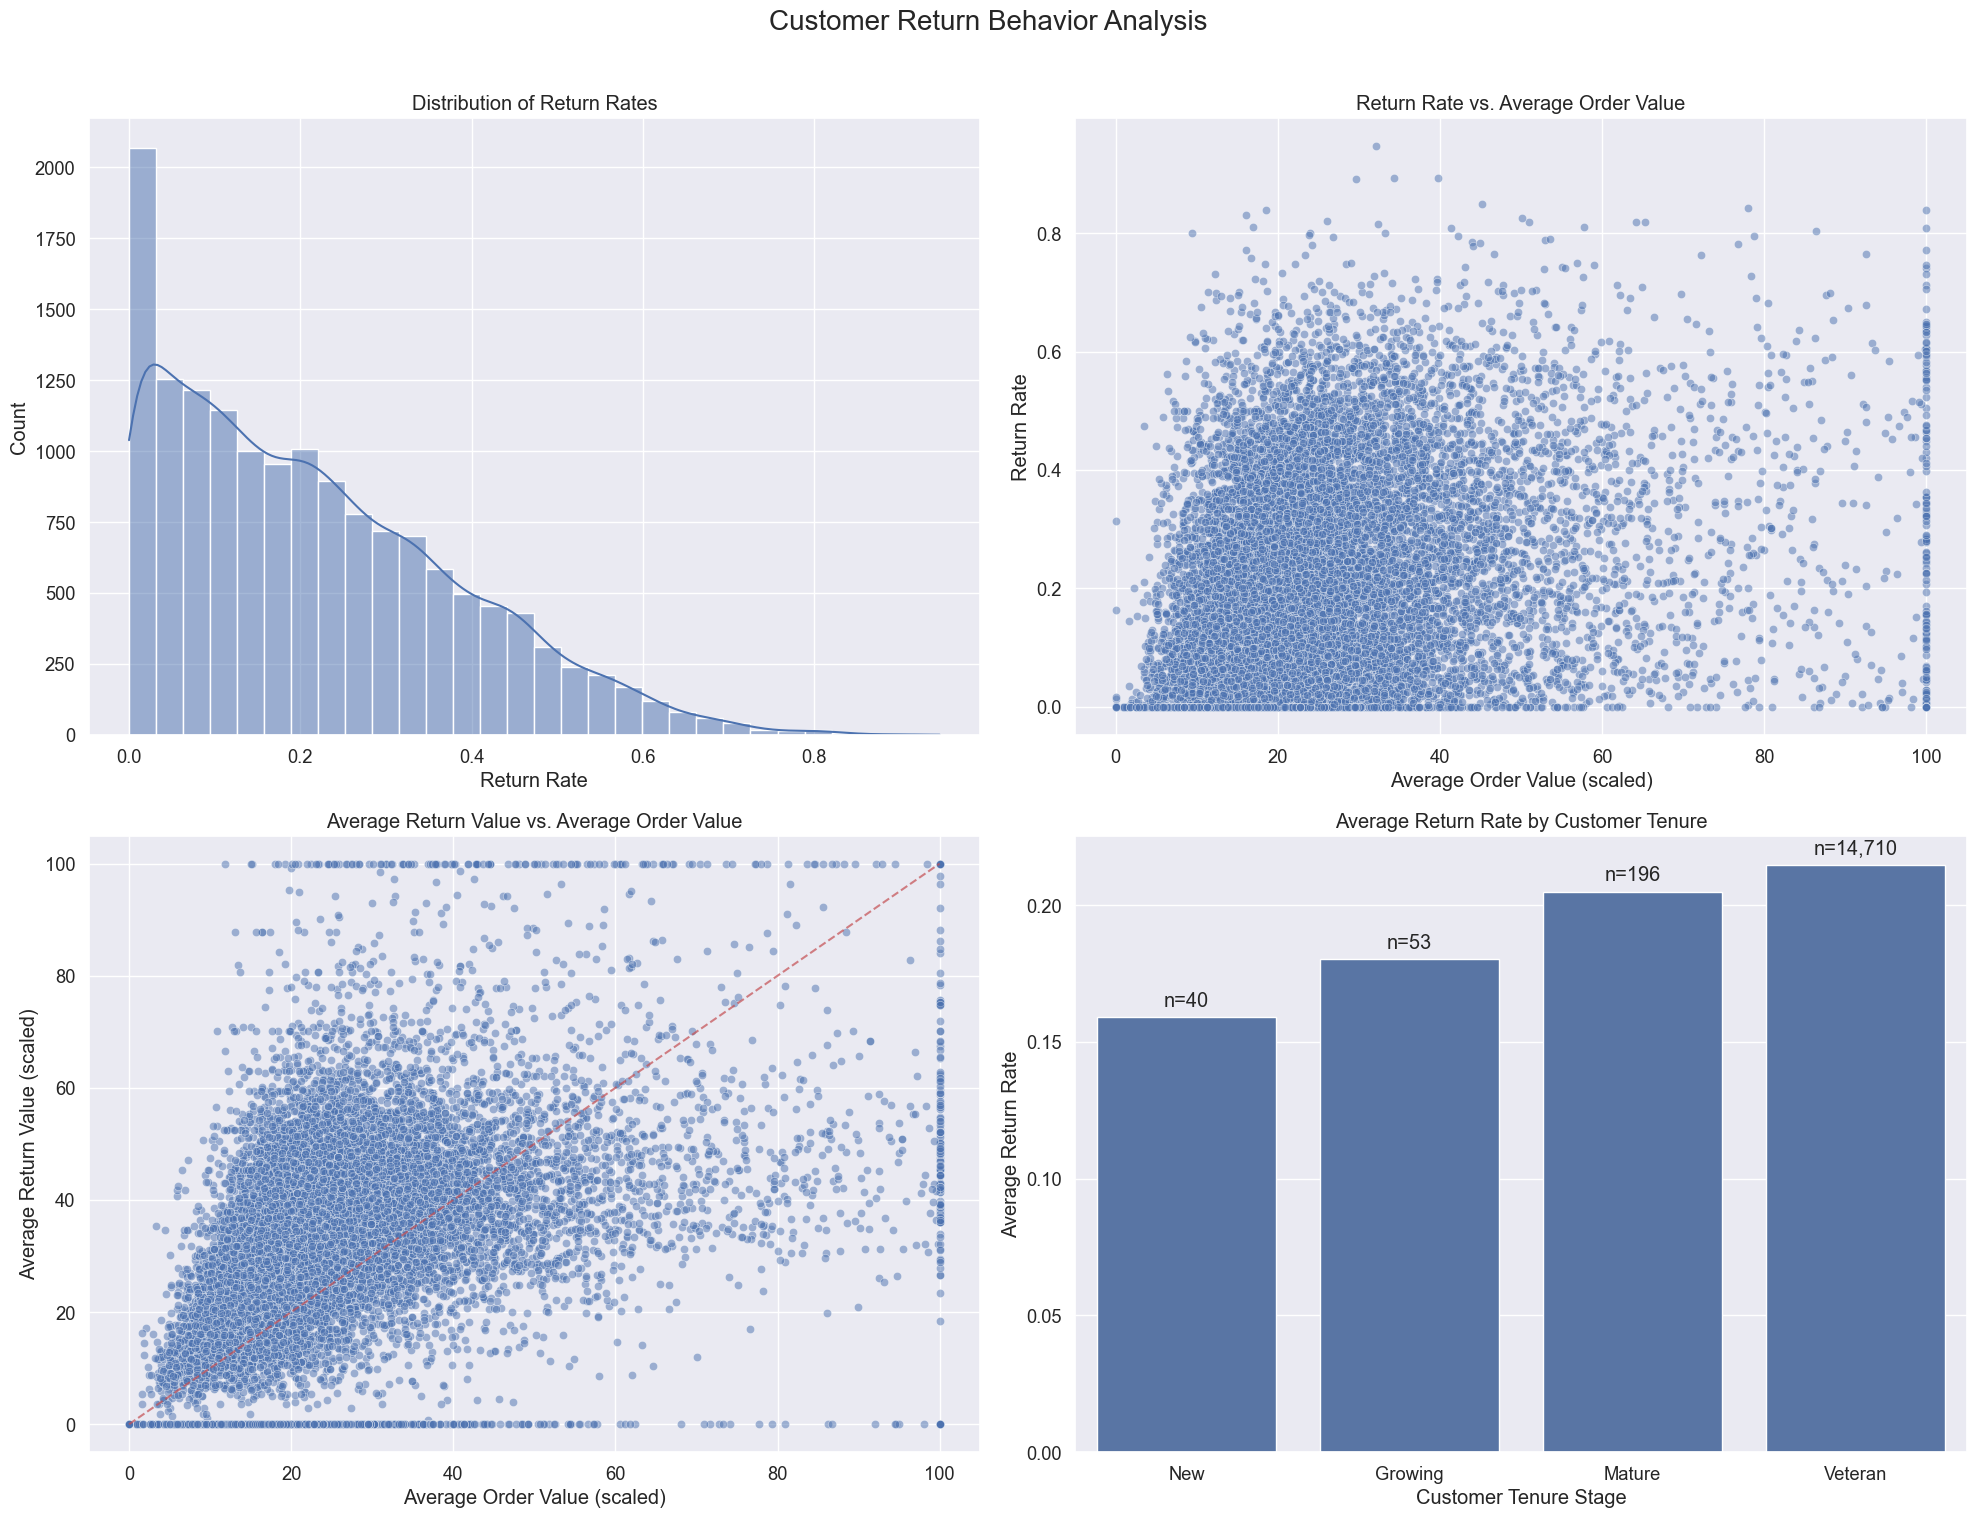

In [8]:
# STEP 3.2: FEATURE VISUALIZATIONS

if PIPELINE_CONFIG['execution_steps']['feature_creation']:
    print("\n" + "="*60)
    print("STEP 3.2: FEATURE VISUALIZATIONS")
    print("="*60)
    
    try:
        print("Generating feature visualizations...")
        
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Set plot style
        plt.style.use('ggplot')
        sns.set(font_scale=1.2)
        
        # Connect to database and get data
        from db import get_connection
        conn = get_connection("customer_clustering.db")
        
        # Query the most important features for visualization
        features_df = conn.execute("""
            SELECT 
                return_rate, 
                avg_order_value, 
                avg_return_value, 
                high_value_return_affinity,
                customer_lifetime_days,
                avg_days_to_return,
                return_product_variety,
                customer_tenure_stage
            FROM silver_customer_features
            WHERE return_rate <= 1.0  -- Filter out outliers
        """).fetchdf()
        
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Return Rate Distribution
        ax1 = fig.add_subplot(2, 2, 1)
        sns.histplot(features_df['return_rate'], bins=30, kde=True, ax=ax1)
        ax1.set_title('Distribution of Return Rates')
        ax1.set_xlabel('Return Rate')
        ax1.set_ylabel('Count')
        
        # 2. Return Rate vs Order Value
        ax2 = fig.add_subplot(2, 2, 2)
        sns.scatterplot(
            data=features_df, 
            x='avg_order_value', 
            y='return_rate',
            alpha=0.5,
            ax=ax2
        )
        ax2.set_title('Return Rate vs. Average Order Value')
        ax2.set_xlabel('Average Order Value (scaled)')
        ax2.set_ylabel('Return Rate')
        
        # 3. Return Value vs Order Value
        ax3 = fig.add_subplot(2, 2, 3)
        sns.scatterplot(
            data=features_df, 
            x='avg_order_value', 
            y='avg_return_value',
            alpha=0.5,
            ax=ax3
        )
        ax3.set_title('Average Return Value vs. Average Order Value')
        ax3.set_xlabel('Average Order Value (scaled)')
        ax3.set_ylabel('Average Return Value (scaled)')
        ax3.plot([0, 100], [0, 100], 'r--', alpha=0.7)  # 1:1 reference line
        
        # 4. Customer Segments by Tenure
        ax4 = fig.add_subplot(2, 2, 4)
        tenure_return_stats = features_df.groupby('customer_tenure_stage')['return_rate'].agg(['mean', 'count'])
        tenure_return_stats = tenure_return_stats.reset_index()
        
        # Sort by natural tenure progression
        tenure_order = ['New', 'Growing', 'Mature', 'Veteran']
        tenure_return_stats['customer_tenure_stage'] = pd.Categorical(
            tenure_return_stats['customer_tenure_stage'], 
            categories=tenure_order, 
            ordered=True
        )
        tenure_return_stats = tenure_return_stats.sort_values('customer_tenure_stage')
        
        bars = sns.barplot(
            data=tenure_return_stats,
            x='customer_tenure_stage',
            y='mean',
            ax=ax4
        )
        ax4.set_title('Average Return Rate by Customer Tenure')
        ax4.set_xlabel('Customer Tenure Stage')
        ax4.set_ylabel('Average Return Rate')
        
        # Add count annotations on bars
        for i, p in enumerate(bars.patches):
            bars.annotate(
                f"n={tenure_return_stats['count'].iloc[i]:,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points'
            )
        
        # Add overall title
        plt.suptitle('Customer Return Behavior Analysis', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        # Save the visualization
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        viz_file = f'customer_features_visualization_{timestamp}.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        
        # Close connection
        conn.close()
        
        print(f"✅ Feature visualizations created and saved to {viz_file}")
        
    except Exception as e:
        print(f"❌ Feature visualization failed: {e}")
        print(traceback.format_exc())
        
        # Continue pipeline even if visualization fails
        print("Continuing with pipeline despite visualization failure...")

In [9]:
# STEP 4: CLUSTER PREPROCESSING

if PIPELINE_CONFIG['execution_steps']['preprocessing']:
    print("\n" + "="*60)
    print("STEP 4: CLUSTER PREPROCESSING")
    print("="*60)
    
    # Set preprocessing parameters
    preprocessing_args = [
        '--scaling', 'robust',
        '--variance-threshold', '0.01',
        '--outlier-contamination', '0.05',
        '--explicit-column-insert', 'true'  # Add explicit column specification to fix table mismatch
    ]
    
    success, result = pipeline.run_python_module('cluster_preprocessing', 'Cluster Preprocessing and Gold Layer Creation', *preprocessing_args)
    
    if success:
        print("✅ Cluster preprocessing completed successfully!")
        print("Gold layer ready for clustering")
        print("\n🎯 Preprocessing completed:")
        print("  - Feature scaling (RobustScaler)")
        print("  - Outlier detection (Isolation Forest)")
        print("  - Low variance feature removal")
        print("  - Data quality validation")
            
    else:
        print(f"❌ Cluster preprocessing failed")
        print(f"Error details: {result}")
        
        if PIPELINE_CONFIG['error_handling']['stop_on_error']:
            print("Stopping pipeline due to error configuration")
            raise Exception("Cluster preprocessing failed")
else:
    print("⏭️ Cluster preprocessing skipped (disabled in configuration)")


STEP 4: CLUSTER PREPROCESSING
2025-06-25 09:39:05,182 - INFO - 4185141521 - Starting: Cluster Preprocessing and Gold Layer Creation
2025-06-25 09:39:07,943 - INFO - 4185141521 - Step 'Cluster Preprocessing and Gold Layer Creation' completed in 2.76 seconds
✅ Cluster preprocessing completed successfully!
Gold layer ready for clustering

🎯 Preprocessing completed:
  - Feature scaling (RobustScaler)
  - Outlier detection (Isolation Forest)
  - Low variance feature removal
  - Data quality validation
2025-06-25 09:39:07,943 - INFO - 4185141521 - Step 'Cluster Preprocessing and Gold Layer Creation' completed in 2.76 seconds
✅ Cluster preprocessing completed successfully!
Gold layer ready for clustering

🎯 Preprocessing completed:
  - Feature scaling (RobustScaler)
  - Outlier detection (Isolation Forest)
  - Low variance feature removal
  - Data quality validation


In [10]:
# STEP 5: CLUSTERING (OPTIONAL)

if PIPELINE_CONFIG['execution_steps']['clustering']:
    print("\n" + "="*60)
    print("STEP 5: CLUSTERING EXECUTION")
    print("="*60)
    
    print("🔄 Automated clustering would run here...")
    print("📓 For now, please run create_clusters.ipynb manually for interactive analysis")
    pipeline.log_step("Clustering", "SKIPPED", details="Manual execution required")
    
else:
    print("\n" + "="*60)
    print("STEP 5: CLUSTERING (SKIPPED)")
    print("="*60)
    print("ℹ️ Clustering execution is disabled in configuration")
    print("📓 To run clustering, execute the create_clusters.ipynb notebook")
    print("\n🎯 Next step: Open and run create_clusters.ipynb")
    pipeline.log_step("Clustering", "SKIPPED", details="Disabled in configuration")


STEP 5: CLUSTERING EXECUTION
🔄 Automated clustering would run here...
📓 For now, please run create_clusters.ipynb manually for interactive analysis
2025-06-25 09:39:07,955 - INFO - 4185141521 - Step 'Clustering' skipped


In [11]:
# PIPELINE COMPLETION AND SUMMARY

print("\n" + "="*80)
print("PIPELINE EXECUTION SUMMARY")
print("="*80)

# Save execution summary
execution_summary = pipeline.save_execution_summary()

# Print summary
total_time = execution_summary['pipeline_execution']['total_duration_formatted']
completed_steps = execution_summary['status_summary']['completed_steps']
total_steps = execution_summary['status_summary']['total_steps']
failed_steps = execution_summary['status_summary']['failed_steps']

print(f"Execution completed in: {total_time}")
print(f"Steps completed: {completed_steps}/{total_steps}")

if failed_steps > 0:
    print(f"❌ {failed_steps} step(s) failed - check logs for details")
    print("\nFailed steps:")
    for log_entry in execution_summary['step_execution_log']:
        if log_entry['status'] == 'FAILED':
            print(f"  - {log_entry['step']}: {log_entry.get('details', {}).get('error_message', 'Unknown error')}")
else:
    print("✅ All enabled steps completed successfully!")

print(f"\n📋 NEXT STEPS:")
if failed_steps == 0:
    if not PIPELINE_CONFIG['execution_steps']['clustering']:
        print("  1. 📓 Execute create_clusters.ipynb for clustering analysis")
        print("  2. 📊 Generate Excel report with: python generate_excel_report.py")
        print("  3. 💼 Review clustering results and business interpretations")
        print("  4. 🚀 Implement customer segmentation in business systems")
    else:
        print("  1. 📊 Generate Excel report with: python generate_excel_report.py")
        print("  2. 💼 Review clustering results in database tables")
        print("  3. ✅ Validate customer segments with business stakeholders")
        print("  4. 🚀 Implement customer segmentation strategies")
else:
    print("  1. 🔍 Review error logs and fix any data quality issues")
    print("  2. 🔄 Re-run failed pipeline steps")
    print("  3. ✅ Proceed with clustering once all steps complete successfully")

print("\n📊 DATABASE TABLES CREATED:")
print("  - bronze_return_order_data (raw data)")
print("  - silver_customer_features (engineered features)")
print("  - gold_cluster_processed (clustering-ready data)")
if PIPELINE_CONFIG['execution_steps']['clustering']:
    print("  - clustering_results (final customer segments)")
    print("  - cluster_summary (segment characteristics)")

print("\n🎯 BUSINESS VALUE:")
print("  - Customer segmentation based on return behavior patterns")
print("  - Identification of high-risk return customers")
print("  - Data-driven insights for retention and satisfaction strategies")
print("  - Foundation for personalized customer experiences")

print("\n" + "="*80)
print(f"Pipeline execution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Show files created
print("\n📁 FILES CREATED:")
files_created = [
    'customer_clustering.db',
    f'pipeline_execution_{datetime.now().strftime("%Y%m%d")}_*.log',
    f'pipeline_execution_summary_{datetime.now().strftime("%Y%m%d")}_*.json'
]

for file_pattern in files_created:
    print(f"  ✅ {file_pattern}")

print("\n🎉 Ready for clustering analysis!")
print("📓 Next: Open and run create_clusters.ipynb")


PIPELINE EXECUTION SUMMARY
2025-06-25 09:39:07,974 - INFO - 4185141521 - Execution summary saved to pipeline_execution_summary_20250625_093907.json
Execution completed in: 0h 1m 0s
Steps completed: 4/5
✅ All enabled steps completed successfully!

📋 NEXT STEPS:
  1. 📊 Generate Excel report with: python generate_excel_report.py
  2. 💼 Review clustering results in database tables
  3. ✅ Validate customer segments with business stakeholders
  4. 🚀 Implement customer segmentation strategies

📊 DATABASE TABLES CREATED:
  - bronze_return_order_data (raw data)
  - silver_customer_features (engineered features)
  - gold_cluster_processed (clustering-ready data)
  - clustering_results (final customer segments)
  - cluster_summary (segment characteristics)

🎯 BUSINESS VALUE:
  - Customer segmentation based on return behavior patterns
  - Identification of high-risk return customers
  - Data-driven insights for retention and satisfaction strategies
  - Foundation for personalized customer experie